# The simplest denoising diffusion model


Denoising diffusion probabilistic models, from the original paper [Ho et al., 2020](https://arxiv.org/abs/2006.11239) to [DALL-E](https://github.com/lucidrains/DALLE-pytorch) and [Stable Diffusion](https://github.com/CompVis/stable-diffusion) are becoming an increasingly successful at image generation.

The goal of this notebook to understand how they work by creating the simplest possible denoising diffusion model. Many existing training materials start with a relatively complex setting, e.g. generating an image. Here we are instead considering a toy model: the sample space is one-dimensional and the set of "realistic" samples consist of just one data point.

A lot of code here is based on [this Huggingface colab notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb). We also refer to [Ho et al., 2020](https://arxiv.org/abs/2006.11239) as "the paper" below

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

## Define initial setup

- The space of all possible samples is $\mathbb{R}$ - all real numbers. For comparison, in the original paper this was a space of all 256x256 images
- The space of training samples consists of one element $x_0$. In the paper it consisted of all the images in the training set, e.g. CIFAR10
- The model needs to generate realistic samples (the number $x_0$ in our case) from noise by iterative denoising

Let's define the hyperparameters:

In [2]:
x0 = -5  # "realistic" sample which the model needs to learn to generate 
n_steps = 100  # number of denoising time steps

Following [the colab notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb), we define some functions of time which will be used below.
First of all, we need to choose how the noise variance changes over time. Following the beginning of section 4 of the paper, we choose variance $1 - \alpha_t$ to change linearly from $0.001$ to $0.2$. We'll also need cumulative product $\bar\alpha_{T} = \prod\limits_{t=0}^{T} \alpha_{t}$ and its square root

In [3]:
alphas = 1. - torch.linspace(0.001, 0.2, n_steps)
alphas_cumprod = torch.cumprod(alphas, axis=0)

sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - sqrt_alphas_cumprod ** 2)

The equation between eqs. (8) an (9) in the paper states that $x_t(x_0, \epsilon) = \sqrt{\bar\alpha_t} x_0 + \sqrt{1 - \bar\alpha_t} \epsilon$. This means the quantities above detemine how much starting point $x_0$ and the noise $\epsilon$ contribute into $x_t$. Let's plot them as functions of time

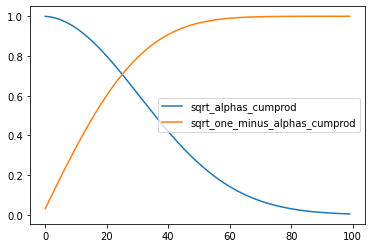

In [4]:
plt.plot(sqrt_alphas_cumprod, label="sqrt_alphas_cumprod")
plt.plot(sqrt_one_minus_alphas_cumprod, label="sqrt_one_minus_alphas_cumprod")
plt.legend()

One can see that the contribution of $x_0$ decreases, and contribution of the noise increases. This is completely in line with our intuition: in the beginning $x_t$ is made mainly of $x_0$ and in the end it's made mainly of noise.

## Define forward diffusion step

The following function allows us to sample $x_t$ given $x_0$ and noise $\epsilon_t$ - see equation above eq. (9) in the paper

In [5]:
def q_sample(x_0, t, noise):
    """
    Sample x at time t given the value of x at t=0 and the noise
    """
    return sqrt_alphas_cumprod.gather(-1, t) * x_0 + sqrt_one_minus_alphas_cumprod.gather(-1, t) * noise

Let's see how distribution of x evolves under the forward process - diffusion. Initially it's peaked at $x_0$, later it becames wider and centers around 0

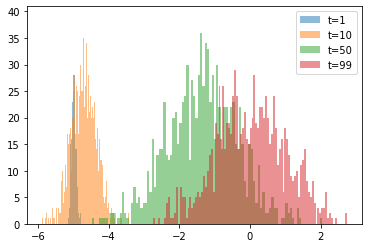

In [6]:
for t in [1, n_steps // 10, n_steps // 2, n_steps - 1]:
    noised_x = q_sample(x0, torch.tensor(t), torch.randn(1000))
    plt.hist(noised_x.numpy(), bins=100, alpha=0.5, label=f"t={t}");
plt.legend()

Below the same process is shown as scatterplot - as we move forward in time (from left to right on the plot), diffusion makes the distribution wider and shift its mean to 0

Text(0, 0.5, 'x')

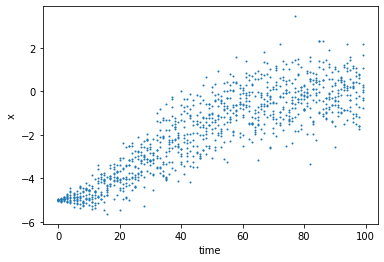

In [7]:
res = [(t, q_sample(x0, torch.tensor(t), torch.randn(1)).item()) for _ in range(10) for t in range(n_steps)]
x, y = list(zip(*res))
plt.scatter(x, y, s=1)
plt.xlabel("time")
plt.ylabel("x")

## Train the model

As section 3.2 of the paper describes, we need to train a model which can predict noise $\epsilon_t$ given 
$x_t$ and $t$. The paper uses a neural net (U-Net) for this purpose. In our, much simpler, setup the model can be linear: $\epsilon_t = a x_t + b t + c$, where a, b, c are trainable parameters

In [8]:
class DenoiseModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.a = torch.nn.Parameter(torch.tensor(1.))
        self.b = torch.nn.Parameter(torch.tensor(0.))
        self.c = torch.nn.Parameter(torch.tensor(0.))
        
    def forward(self, x, t):
        return self.a * x + self.b * t + self.c

How to define a loss function? We create an instance of noise (sampled from a normal distribution) and use it to generate "noisy" $x_t$. Then we apply our model to predict the noise value based on the "noisy" $x_t$ and time $t$. The closer this predicted value is to the value of the noise we sampled initially, the better the model is:

In [9]:
def p_loss(x, t):
    # Generate a noise
    noise = torch.randn(t.shape)
    # Compute x at time t with this value of the noise - forward process
    noisy_x = q_sample(x, t, noise)
    # Use our trained model to predict the value of the noise, given x(t) and t
    noise_computed = denoise(noisy_x, t)
    # Compare predicted value of the noise with the actual value
    return F.mse_loss(noise, noise_computed)

Below we run a simple PyTorch training loop: pick a random time step $t$, compute a loss at that time step (squared difference between actual and predicted noise), and adjust parameters $a, b, c$ based on gradients of this loss

In [10]:
denoise = DenoiseModel()
optimizer = torch.optim.Adam(denoise.parameters())

n_epochs = 10000
batch_size = 1000
for step in range(n_epochs):
    optimizer.zero_grad()
    t = torch.randint(0, n_steps, (batch_size, ))  # Pick random time step
    loss = p_loss(x0, t)
    loss.backward()
    if step % (n_epochs // 10) == 0:
        print(f"loss={loss.item():.4f}; a={denoise.a.item():.4f}, b={denoise.b.item():.4f}, c={denoise.c.item():.4f}")
    optimizer.step()
print(f"final: loss={loss.item():.4f}; a={denoise.a.item():.4f}, b={denoise.b.item():.4f}, c={denoise.c.item():.4f}")

loss=7.0564; a=1.0000, b=0.0000, c=0.0000
loss=0.7804; a=0.3566, b=-0.0051, c=0.6859
loss=0.6137; a=0.2855, b=-0.0114, c=0.9894
loss=0.6221; a=0.3447, b=-0.0153, c=1.3249
loss=0.5132; a=0.4294, b=-0.0209, c=1.7759
loss=0.4013; a=0.5255, b=-0.0274, c=2.3121
loss=0.3581; a=0.6247, b=-0.0345, c=2.8700
loss=0.3105; a=0.7215, b=-0.0408, c=3.3775
loss=0.2929; a=0.7900, b=-0.0463, c=3.7748
loss=0.2902; a=0.8334, b=-0.0489, c=4.0234
final: loss=0.2825; a=0.8534, b=-0.0508, c=4.1404


## Define reverse process step

Once the model is trained, we can use it to implement "backward process" (Algorith 2 from the paper). We'll go step by step from $t=99$ to $t=0$, at every step "denoising" $x_t$ to produce $x_{t-1}$. The function `p_sample` below performs one such step. Remeber  that $x_{t - 1}$ is distributed normally given $x_{t}$ - the function finds mean and variance of this distribution and then samples from it

- For posterior mean, see eq. (11) in the paper, also reused in Algorithm 2
- For posterior variance, see the beginning of section 3.2 in the paper (or eq. (7))

In [11]:
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
posterior_variance = (1 - alphas) * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def p_sample(x, t):
    """
    One step of revese process sampling - Algorithm 2 from the paper
    """
    alpha_t = alphas.gather(-1, t)
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod.gather(-1, t)
    # Get mean x[t - 1] conditioned at x[t] - see eq. (11) in the paper
    model_mean = torch.sqrt(1.0 / alpha_t) * (x - (1 - alpha_t) * denoise(x, t) / sqrt_one_minus_alphas_cumprod_t)
    # Get variance of x[t - 1]
    model_var = posterior_variance.gather(-1, t)
    # Samples for the normal distribution with given mean and variance
    return model_mean + torch.sqrt(model_var) * torch.randn(1)

Below we apply reverse process for different random starting points $x_{100}$. You could see that all of them converge to the vicinity of true $x_0 = -5$

Text(0.5, 1.0, 'Reverse process - denoising')

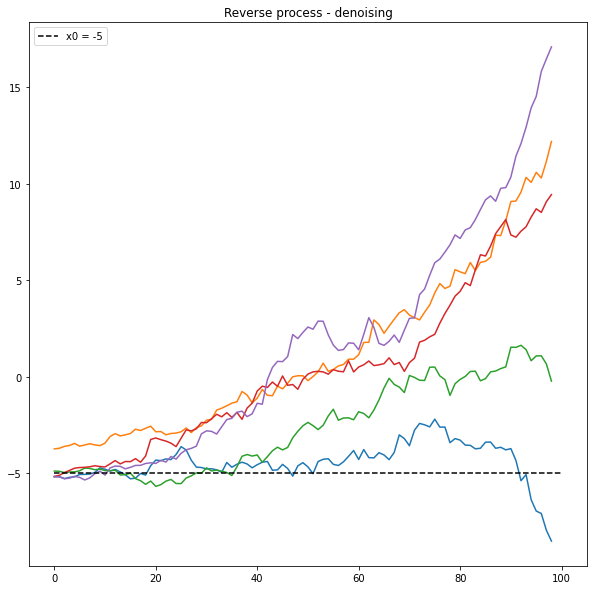

In [12]:
plt.figure(figsize=(10, 10))
for _ in range(5):
    x_gens = []
    x_gen = torch.randint(-50, 50, (1,))
    for i in range(n_steps - 1, 0, -1):
        x_gen = p_sample(x_gen, torch.tensor(i))
        x_gens.append(x_gen.detach().numpy()[0])
    plt.plot(x_gens[::-1])
plt.hlines(x0, 0, 100, color="black", linestyle="--", label=f"x0 = {x0}")
plt.legend(loc="upper left")
plt.title("Reverse process - denoising")

Let's also see how the distribution of $x$ evolves under the reverse "denoising" process

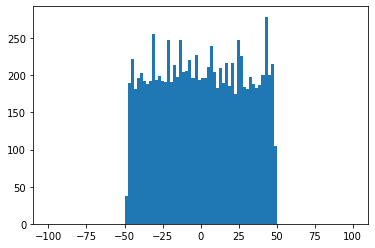

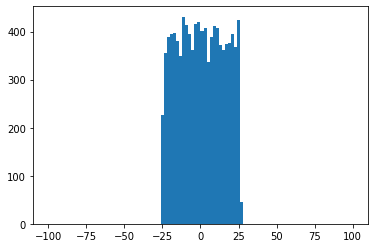

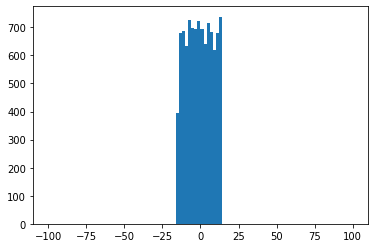

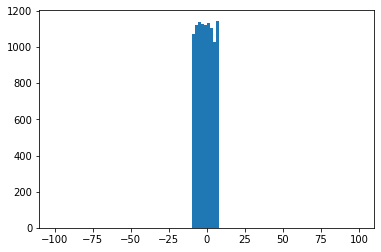

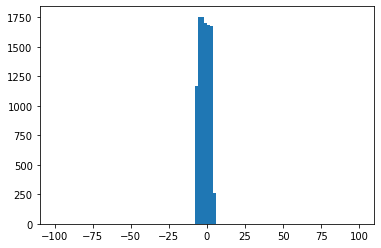

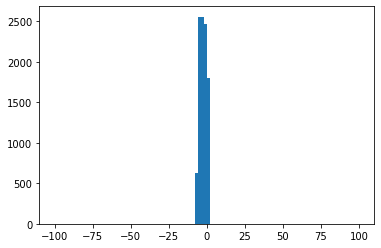

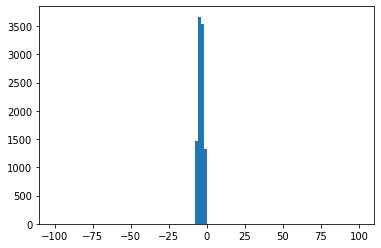

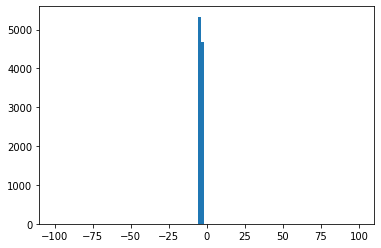

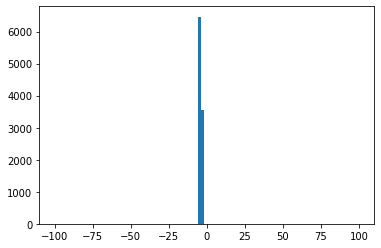

In [13]:
# Create a sample of 10000 "noisy" datapoint at time t = 100
x_gen = torch.randint(-100, 100, (10000,))
for i in range(n_steps - 1, 0, -1):
    # denoise the sample step by step backawards in time
    x_gen = p_sample(x_gen, torch.tensor(i))
    if i % 10 == 0:
        plt.hist(x_gen.detach().numpy(), range=(-100, 100), bins=100)
        plt.show()

# Appendix

## Is the noise really linear?

You could experiment with different values of `x_0` and `n_steps` and notice that convergence gets better or worse depending on them. One of the reasons is that our model for predicting noise is really simple - it's linear in $t$ and $x$. 

In this section we plot how the actual noise depends on $t$ and $x$. It can be done in two ways: by simulation and by using an explit formula from the paper

#### Simulate noise

In [14]:
from collections import defaultdict

x_scale = 4 # Range of x to plot
all_res = []
for t0 in range(n_steps): # Go over all time steps and over x in a certain range
    res = defaultdict(list)
    for x in np.linspace(-x_scale, x_scale, 10):
        noise_size = 1000
        # Generate noise and apply it to x to get "noisy" x
        noise = torch.randn((noise_size, 1))
        t = torch.tensor((t0,))
        noisy_x = q_sample(x0, t, noise)
        bin_size = 0.01
        # Group data by "noisy" x and compute average value of noise for a given "noisy" x
        noisy_quantised = ((noisy_x[:, 0] / bin_size).round() * bin_size).numpy()
        for i in range(noise_size):
            res[noisy_quantised[i]].append(noise[i, 0].item())
    averaged = {k: np.mean(res[k]) for k in res}
    x_noisy = list(averaged.keys())
    for k in averaged:
        all_res.append([t0, k, averaged[k]])

#### Explicitly compute noise

As stated in the paper, $x_t(x_0, \epsilon) = \sqrt{\bar\alpha_t} x_0 + \sqrt{1 - \bar\alpha_t} \epsilon$. Expressing the noise $\epsilon$ from here we can compute noise given "noisy" $x_t$, initial value $x_0$, and time $t$

In [15]:
def get_noise(x_noisy, x0, t):
    return (x_noisy - x0 * sqrt_alphas_cumprod[t]) / sqrt_one_minus_alphas_cumprod[t]

#### Plot computed and simulated noise as a function of $x$, for a given $t$

Plotting the noise as a function of $x$ for different fixed values of $t$, one can see that dependence on $x$ is linear. Of course, the simulated and computed values conicide

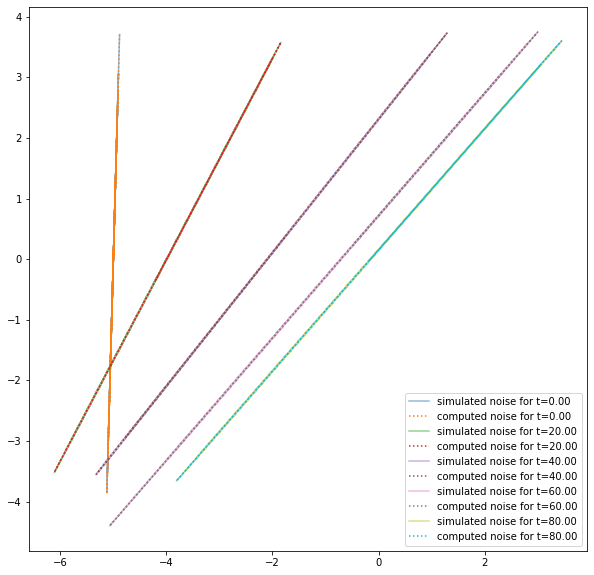

In [16]:
plt.figure(figsize=(10, 10))
for t in range(0, n_steps, n_steps // 5):
    all_fixed_t = [val for val in all_res if val[0] == t]
    x_axis = [val[1] for val in all_fixed_t]
    plt.plot(x_axis, [val[2] for val in all_fixed_t], label=f"simulated noise for t={t:.2f}", linestyle="-", alpha=0.5)
    computed_noise = [get_noise(val[1], x0, t)  for val in all_fixed_t]
    plt.plot(x_axis, computed_noise, label=f"computed noise for t={t:.2f}", linestyle=":")
plt.legend(loc="lower right")

#### Plot computed and simulated noise as a function of $t$, for a given $x$

Dependence on $t$ is non-linear in general, but can be approximated by a linear function for some $x$

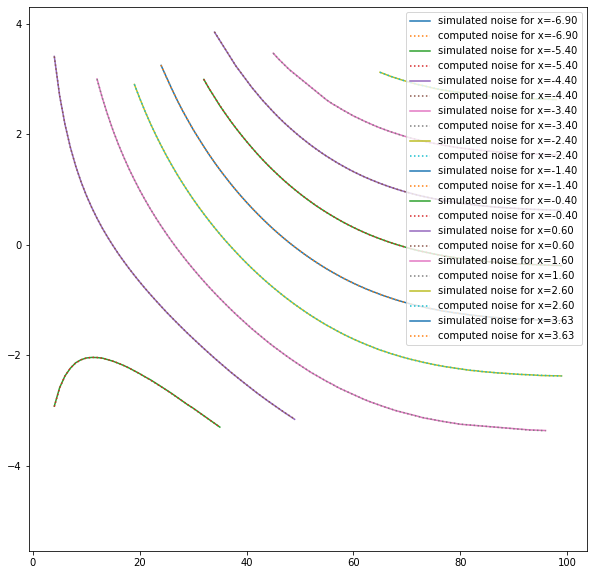

In [17]:
possible_noisy_x = sorted(set([val[1] for val in all_res]))
plt.figure(figsize=(10, 10))
for x_fixed in possible_noisy_x[::n_steps]:
    all_fixed_x = [x for x in all_res if np.abs(x[1] - x_fixed) < 1e-8]
    x_axis = [val[0] for val in all_fixed_x]
    plt.plot(x_axis, [val[2] for val in all_fixed_x], label=f"simulated noise for x={x_fixed:.2f}", linestyle="-")
    computed_noise = [get_noise(x_fixed, x0, val[0])  for val in all_fixed_x]
    plt.plot(x_axis, computed_noise, label=f"computed noise for x={x_fixed:.2f}", linestyle=":")
plt.legend(loc="upper right")